In [2]:
cd ..

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing


In [3]:
import os
os.environ['TRANSFORMERS_CACHE'] = '/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/downloads'
os.environ['HF_DATASETS_CACHE'] = '/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/downloads'
os.environ['TRANSFORMERS_OFFLINE'] = '1'

In [4]:
import datasets
from datasets import load_dataset
import matplotlib.pyplot as plt
import spacy_alignments as tokenizations
import numpy as np
import pandas as pd
import seaborn as sns
from transformer_lens.utils import gelu_fast
import math
import torch
from probing_datasets.ewt import *
from activations.activation_all import load_activation_all
from circuitsvis.tokens import colored_tokens
import einops

from load import *
from analysis.load_results import *

from activations.activation_subset import *
from analysis.plots.context_neurons import *
from argparse import Namespace

%load_ext autoreload
%autoreload 2


%matplotlib inline

In [5]:
model = load_model('pythia-70m')
decoded_vocab = {t: model.tokenizer.decode(t) for t in model.tokenizer.get_vocab().values()}

No pythia-70m-v0 available


Using pad_token, but it is not set yet.


Loaded pretrained model pythia-70m into HookedTransformer


In [6]:
model_name = 'pythia-70m'
dataset_name = 'natural_lang_id.pyth.512.-1'
experiment_name = 'context_monosemantic'
feature='French'
neuron=(3, 609)

dataset = load_feature_dataset(dataset_name)

# activations on europarl
act_subset_dict, _, europarl_vocab_df = load_activation_subset(model_name, dataset_name, experiment_name)
ep_activations = act_subset_dict[neuron].dequantize()
del act_subset_dict

# ablations on europarl
europarl_neuron_ablation_file = os.path.join('results', 'ablations', 'pythia-70m', 'natural_lang_id.pyth.512.-1', 'ablated_loss_3_609.pt')
europarl_nominal_file = os.path.join('results', 'ablations', 'pythia-70m', 'natural_lang_id.pyth.512.-1', 'nominal_loss.pt')
europarl_ablation = torch.load(europarl_neuron_ablation_file).numpy().astype(np.float32)
europarl_nominal_loss = torch.load(europarl_nominal_file).numpy().astype(np.float32)
europarl_loss_dif = europarl_nominal_loss - europarl_ablation



/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [64]:
def display_seqs(seqs):
    for i in seqs:
        i = int(i)
        token_list = [decoded_vocab[t] for t in dataset[i]['tokens'].tolist()]
        activation_list = ep_activations[i].tolist()
        display(colored_tokens(token_list, activation_list))

In [26]:
fds_len, d = dataset['tokens'].shape

ep_activation_df = pd.DataFrame({
        'token': dataset['tokens'].flatten().numpy().astype(np.uint16),
        'activation': ep_activations.flatten().numpy(),
        'label': einops.repeat(np.array(dataset['lang']), 'b -> b l', l=d).flatten() == 'fr',
        'class': einops.repeat(np.array(dataset['lang']), 'b -> b l', l=d).flatten(),
        'seq_ix': einops.repeat(np.arange(fds_len), 'b -> b l', l=d).flatten().astype(np.uint32),
        'pos_ix': einops.repeat(np.arange(d), 'l -> b l', b=fds_len).flatten().astype(np.uint32)
})

nominal_loss = np.clip(europarl_nominal_loss.flatten(), 1e-8, 1e2)
ablated_loss = np.clip(europarl_ablation.flatten(), 1e-8, 1e2)

ep_ablation_df = pd.DataFrame({
        'cur_token': dataset['tokens'][:, :-1].flatten().numpy().astype(np.uint16),
        'next_token': dataset['tokens'][:, 1:].flatten().numpy().astype(np.uint16),
        'nominal_loss': nominal_loss,
        'ablated_loss': ablated_loss,
        'loss_increase': ablated_loss - nominal_loss,
        'activation': ep_activations[:, :-1].flatten().numpy(),
        'label': einops.repeat(np.array(dataset['lang']), 'b -> b l', l=d-1).flatten() == 'fr',
        'class': einops.repeat(np.array(dataset['lang']), 'b -> b l', l=d-1).flatten(),
        'seq_ix': einops.repeat(np.arange(fds_len), 'b -> b l', l=d-1).flatten().astype(np.uint32),
        'pos_ix': einops.repeat(np.arange(d-1), 'l -> b l', b=fds_len).flatten().astype(np.uint32)
})

<AxesSubplot: xlabel='activation', ylabel='count'>

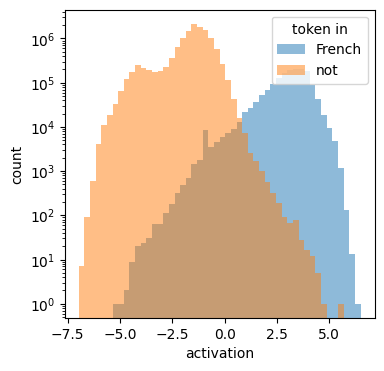

In [8]:
token_histogram_by_class(ep_activation_df, plot_dist=False, logy=True, pos_label=feature)

<AxesSubplot: xlabel='activation', ylabel='count'>

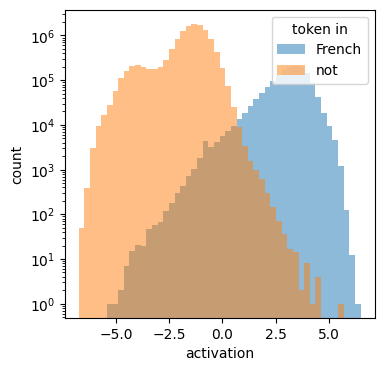

In [27]:
token_histogram_by_class(ep_activation_df.query('pos_ix > 10'), plot_dist=False, logy=True, pos_label=feature)

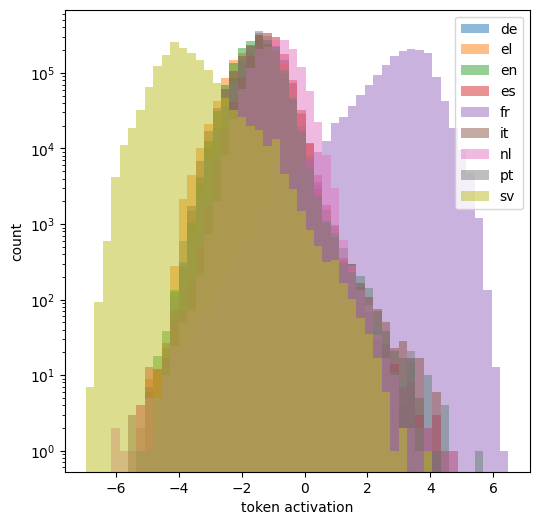

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
_, bins = np.histogram(ep_activation_df.activation.values, bins=50)
for cls, df in ep_activation_df.groupby('class'):
    ax.hist(df.activation.values, bins=bins, alpha=0.5, label=cls)
ax.set_yscale('log')
ax.set_xlabel('token activation')
ax.set_ylabel('count')
ax.legend()

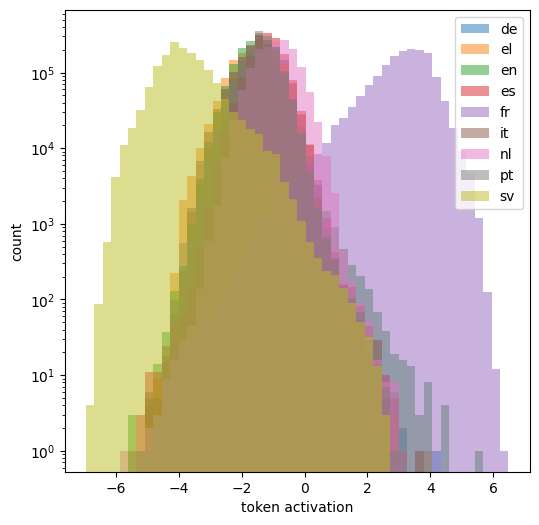

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
_, bins = np.histogram(ep_activation_df.activation.values, bins=50)
for cls, df in ep_activation_df.query('pos_ix > 10').groupby('class'):
    ax.hist(df.activation.values, bins=bins, alpha=0.5, label=cls)
ax.set_yscale('log')
ax.set_xlabel('token activation')
ax.set_ylabel('count')
ax.legend()

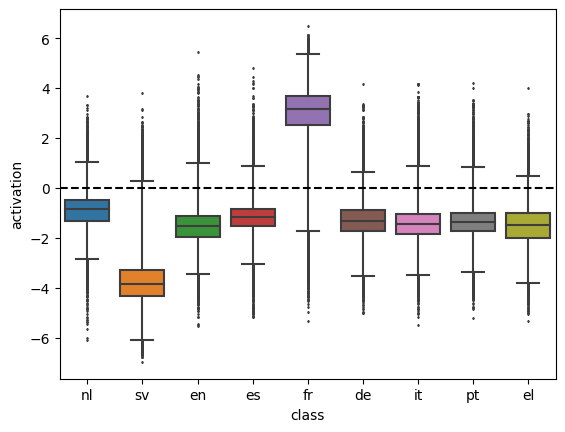

In [25]:
ax = sns.boxplot(x='class', y='activation', data=ep_activation_df, whis=(0.1, 99.9), fliersize=1)
ax.axhline(0, color='black', linestyle='--')

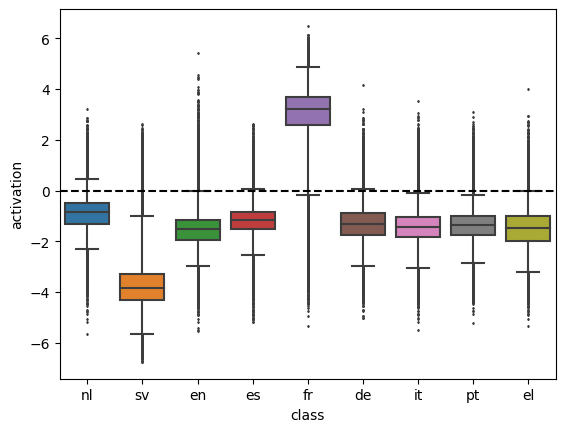

In [34]:
ax = sns.boxplot(x='class', y='activation', data=ep_activation_df.query('pos_ix > 10'), whis=(1, 99), fliersize=1)
ax.axhline(0, color='black', linestyle='--')

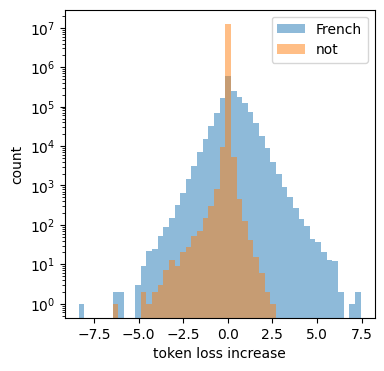

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
_, bins = np.histogram(ep_ablation_df.loss_increase.values, bins=50)
class_loss = ep_ablation_df.query('label == True').loss_increase.values
other_loss = ep_ablation_df.query('label == False').loss_increase.values
ax.hist(class_loss, bins=bins, alpha=0.5, label=feature)
ax.hist(other_loss, bins=bins, alpha=0.5, label='not');
ax.set_yscale('log')
ax.set_xlabel('token loss increase')
ax.set_ylabel('count')
ax.legend()

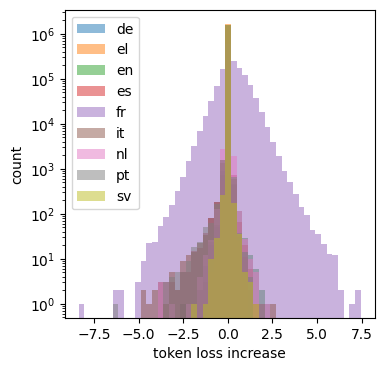

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
_, bins = np.histogram(ep_ablation_df.loss_increase.values, bins=50)
for cls, df in ep_ablation_df.groupby('class'):
    ax.hist(df.loss_increase.values, bins=bins, alpha=0.5, label=cls)
ax.set_yscale('log')
ax.set_xlabel('token loss increase')
ax.set_ylabel('count')
ax.legend()

<AxesSubplot: xlabel='class', ylabel='loss_increase'>

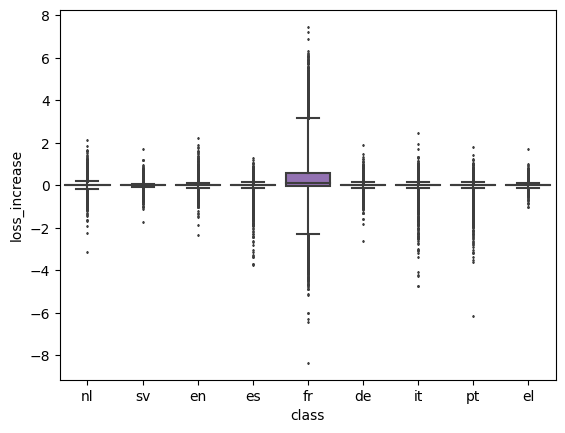

In [15]:
sns.boxplot(x='class', y='loss_increase', data=ep_ablation_df, whis=(0.1, 99.9), fliersize=1)

In [58]:
# take the average activation for each token over sequence and a random class id
ep_activation_df['relu'] = ep_activation_df.activation.apply(lambda x: max(0, x))
seq_act_df = ep_activation_df.groupby('seq_ix').agg({'relu': ['mean', 'max'], 'class': [lambda x: x.sample(1).values[0]]}).reset_index(drop=True)#.groupby('class').agg({'activation': 'mean'}).plot.bar()
seq_act_df.columns = ['avg_act', 'max_act', 'cls']

In [44]:
# reset columns


In [45]:
seq_act_df

,avg_act,max_act,class
0,0.020820,0.949884,nl
1,0.009173,1.372054,nl
2,0.011544,0.738798,nl
3,0.011338,0.686027,nl
4,0.011750,0.844341,nl
...,...,...,...
28079,0.002680,0.316628,el
28080,0.000206,0.105543,el
28081,0.005050,0.422171,el
28082,0.000825,0.158314,el


In [49]:
# take the average activation for each token over sequence and a random class id
ep_ablation_df['relu'] = ep_ablation_df.loss_increase.apply(lambda x: max(0, x))
seq_ablation_df = ep_ablation_df.groupby('seq_ix').agg({'relu': ['mean', 'max']}).reset_index(drop=True)
seq_ablation_df.columns = ['avg_loss_inc', 'max_loss_inc']

In [59]:
seq_df = pd.concat([seq_ablation_df, seq_act_df], axis=1)

In [61]:
seq_df.query('cls != "fr"').sort_values('avg_loss_inc', ascending=False).head(10)

,avg_loss_inc,max_loss_inc,avg_act,max_act,cls
9220,0.028450,1.904297,0.102244,3.482907,en
8790,0.027983,2.234375,0.146049,3.271822,en
8752,0.018795,1.552734,0.104924,4.485562,en
23008,0.017981,1.800781,0.046381,2.691337,pt
7831,0.017602,1.726562,0.075653,4.538333,en
8451,0.017284,1.457031,0.106058,3.535678,en
2748,0.016529,1.597656,0.045660,2.955194,nl
77,0.016269,0.773438,0.050607,2.849651,nl
1424,0.016145,1.339844,0.079775,2.163624,nl
17126,0.016031,1.324219,0.074210,4.168934,de


In [62]:
seq_df.query('cls != "fr"').sort_values('avg_act', ascending=False).head(10)

,avg_loss_inc,max_loss_inc,avg_act,max_act,cls
8790,0.027983,2.234375,0.146049,3.271822,en
8759,0.015513,1.082031,0.143472,5.435446,en
780,0.011719,0.255859,0.108532,2.163624,nl
8451,0.017284,1.457031,0.106058,3.535678,en
8752,0.018795,1.552734,0.104924,4.485562,en
9220,0.028450,1.904297,0.102244,3.482907,en
8286,0.009188,0.306641,0.088330,3.007965,en
6241,0.006301,0.417969,0.085753,2.585795,en
1424,0.016145,1.339844,0.079775,2.163624,nl
7831,0.017602,1.726562,0.075653,4.538333,en


In [69]:
seqs = seq_df.query('cls != "fr"').sort_values('avg_act', ascending=False).head(10).index.values
display_seqs(seqs)


In [ ]:
ep_activation_df.groupby('seq_ix').agg({'activation': ['mean', 'max'], 'class': [lambda x: x.sample(1).values[0]]}).reset_index(drop=True)#.groupby('class').agg({'activation': 'mean'}).plot.bar()

- Histogram by language
- Look at top activating dataset examples for each language
- Do same thing on all pile but by subset
- Look at activation for tokens, ablation for token and loss of next token
- Histogram of subdistributions activations, with spectrum of activations

In [17]:
ep_activation_df

,token,activation,label,class,seq_ix
0,0,-0.949884,False,nl,0
1,29508,-1.846996,False,nl,0
2,8636,-1.160969,False,nl,0
3,1441,-1.160969,False,nl,0
4,3889,-1.741454,False,nl,0
...,...,...,...,...,...
14379003,187,-1.055426,False,el,28083
14379004,14,-0.738798,False,el,28083
14379005,40399,-1.635911,False,el,28083
14379006,21394,-2.533023,False,el,28083


In [10]:
not_french_vocab_df = ep_activation_df.query('label == False').groupby('token')['activation'].agg(['mean', 'max', 'count']).sort_values('mean', ascending=False)
not_french_vocab_df['str'] = not_french_vocab_df.index.map(decoded_vocab)
not_french_vocab_df.query('count > 20').head(10)


,mean,max,count,str
token,,,,
47576,1.675978,2.849651,162,Pierre
36063,1.543072,2.902422,54,Jacques
13089,1.404529,2.744109,169,Jean
29560,1.215851,2.585795,25,Aub
22889,1.196150,2.005310,30,Bour
42231,1.133144,1.952539,55,Cass
10133,1.080902,2.744109,29,ère
45969,1.066093,4.802190,94,autre
36751,1.011957,3.219050,295,Jean


In [11]:
not_french_vocab_df.loc[8684]

mean     0.688289
max      2.216395
count          70
str          Math
Name: 8684, dtype: object

In [12]:
not_french_vocab_ablation_df = ep_ablation_df.query('label == False').groupby('cur_token')['loss_increase'].agg(['mean', 'max', 'count']).sort_values('mean', ascending=False)
not_french_vocab_ablation_df['str'] = not_french_vocab_ablation_df.index.map(decoded_vocab)
not_french_vocab_ablation_df.query('count > 20').head(10)


,mean,max,count,str
cur_token,,,,
18810,0.217793,0.812500,32,illes
44025,0.215265,0.613281,45,Tou
47576,0.187272,0.764648,162,Pierre
8684,0.119438,0.341797,70,Math
2906,0.102903,0.707031,77,Ar
22547,0.093875,0.304688,24,Bernard
21088,0.089490,0.804688,52,Marie
17625,0.087477,0.509766,39,coup
13089,0.083009,0.945312,168,Jean


In [13]:
not_french_vocab_ablation_df = ep_ablation_df.query('label == False').groupby('next_token')['loss_increase'].agg(['mean', 'max', 'count']).sort_values('mean', ascending=False)
not_french_vocab_ablation_df['str'] = not_french_vocab_ablation_df.index.map(decoded_vocab)
not_french_vocab_ablation_df.query('count > 20').head(10)


,mean,max,count,str
next_token,,,,
8684,0.445367,1.312500,70,Math
44025,0.333596,1.464844,45,Tou
24632,0.135075,1.699219,53,illon
17173,0.118985,0.292969,44,LV
4006,0.108324,0.726562,91,bon
1923,0.105422,0.617188,34,ault
26137,0.098150,0.707031,64,lette
26809,0.098086,0.312500,394,HU
29560,0.095859,0.636719,25,Aub


In [14]:
seq_label = np.array(dataset['lang']) == 'fr'
np.argsort(np.maximum(ep_activations, 0).max(axis=1)[0].numpy() - 20 * seq_label)[-20:]

array([27498, 23435, 10764, 11423, 21398, 17126, 19269, 20187,  8579,
       19906, 18987, 21475, 24650, 12070,  9558, 11990,  8752,  7831,
       10654,  8759])

In [15]:
seq_label[14041]

True

In [16]:
(1 - 20 * seq_label)[14041]

-19

In [16]:
8684

8684

In [63]:
seqs = np.argsort(np.maximum(ep_activations, 0).max(axis=1)[0].numpy() - 20 * seq_label)[-3:]
def display_seqs(seqs):
    for i in seqs:
        i = int(i)
        token_list = [decoded_vocab[t] for t in dataset[i]['tokens'].tolist()]
        activation_list = ep_activations[i].tolist()
        display(colored_tokens(token_list, activation_list))

NameError: name 'seq_label' is not defined

In [18]:
display_seqs(seqs)

In [81]:
token_list = [decoded_vocab[t] for t in dataset[i]['tokens'].tolist()[:-1]]
ablation_list = europarl_loss_dif[i].tolist()
colored_tokens(token_list, ablation_list)

In [56]:
cur_token_loss_increase = ep_ablation_df.groupby('cur_token')['loss_increase'].agg(['mean', 'max', 'count'])
cur_token_loss_increase['str'] = cur_token_loss_increase.index.map(decoded_vocab)

next_token_loss_increase = ep_ablation_df.groupby('next_token')['loss_increase'].agg(['mean', 'max', 'count'])
next_token_loss_increase['str'] = next_token_loss_increase.index.map(decoded_vocab)


In [57]:
cur_token_loss_increase.query('count > 50').sort_values('mean', ascending=False)

,mean,max,count,str
cur_token,,,,
7765,1.796773,6.222412,491,soul
2318,1.003362,4.646484,352,ple
14790,0.776857,2.871094,87,roit
13439,0.662408,3.053711,72,progressive
45157,0.654379,1.695312,82,opinion
...,...,...,...,...
13932,-0.109023,1.425781,132,uple
6195,-0.117240,1.199219,206,lit
26542,-0.135712,2.285156,56,cite


In [59]:
next_token_loss_increase.query('count > 50').sort_values('mean', ascending=False)

,mean,max,count,str
next_token,,,,
14675,2.421296,4.646484,125,inement
35892,2.347112,6.222412,267,igner
7290,2.207470,4.564453,95,venue
35200,2.021946,4.531250,185,aide
16322,1.908884,4.113281,99,disposition
...,...,...,...,...
25659,-0.449814,0.054688,65,Cauc
44271,-0.497630,1.515625,53,lé
26238,-0.537124,0.039062,130,lac


In [31]:
# map the tokens to their decoded vocab
#ep_activation_df['token'] = ep_activation_df['token'].map(decoded_vocab)
# get mean count and max activation for each token
token_means = ep_activation_df.groupby('token')['activation'].agg(['mean', 'max', 'count']).sort_values('mean', ascending=False).reset_index()
token_means['str'] = token_means['token'].map(decoded_vocab)



In [32]:
token_means

,token,mean,max,count,str
0,24241,5.114990,6.490872,1089,peut
1,37179,5.035013,6.121473,789,suis
2,4591,4.947678,6.015930,2230,Je
3,41199,4.882940,5.804845,1275,doit
4,12397,4.684488,6.121473,1085,rait
...,...,...,...,...,...
31503,11546,-5.310438,-2.163624,244,full
31504,17433,-5.321908,-2.321938,264,unders
31505,18882,-5.343717,-1.372054,871,tid
31506,4230,-5.541283,-0.791570,8608,har


/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [ ]:


# activations on europarl
act_subset_dict, _, europarl_vocab_df = load_activation_subset(model_name, dataset_name, experiment_name)
ep_activations = act_subset_dict[neuron].dequantize()
del act_subset_dict

# ablations on europarl
europarl_neuron_ablation_file = os.path.join('results', 'ablations', 'pythia-70m', 'natural_lang_id.pyth.512.-1', 'ablated_loss_3_609.pt')
europarl_nominal_file = os.path.join('results', 'ablations', 'pythia-70m', 'natural_lang_id.pyth.512.-1', 'nominal_loss.pt')
europarl_ablation = torch.load(europarl_neuron_ablation_file).numpy().astype(np.float32)
europarl_nominal_loss = torch.load(europarl_nominal_file).numpy().astype(np.float32)
europarl_loss_dif = europarl_nominal_loss - europarl_ablation



In [131]:
# activations on all pile
model_name = 'pythia-70m'
dataset_name = 'pile_test.pyth.512.-1'
experiment_name = 'context_monosemantic'
feature='French'
neuron=(3, 609)

dataset = load_feature_dataset(dataset_name)

act_subset_dict, _, pile_vocab_df = load_activation_subset(model_name, dataset_name, experiment_name)
pile_activations = act_subset_dict[neuron].dequantize()
del act_subset_dict


pile_neuron_ablation_file = os.path.join('results', 'ablations', 'pythia-70m', 'pile_test.pyth.512.-1', 'ablated_loss_3_609.pt')
pile_nominal_file = os.path.join('results', 'ablations', 'pythia-70m', 'pile_test.pyth.512.-1', 'nominal_loss.pt')
pile_ablation = torch.load(pile_neuron_ablation_file).numpy().astype(np.float32)
pile_nominal_loss = torch.load(pile_nominal_file).numpy().astype(np.float32)
pile_loss_dif = pile_ablation - pile_nominal_loss

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [80]:
distr_mapping = {v: i for i, v in enumerate(np.unique(np.array(dataset['distribution'])))}

In [86]:
distr_keys = np.array(list(map(lambda x: distr_mapping[x], dataset['distribution'])), dtype=np.uint8)

In [105]:
len(distr_mapping)

22

In [133]:
fds_len, d = dataset['tokens'].shape

pile_activation_df = pd.DataFrame({
        'token': dataset['tokens'].flatten().numpy().astype(np.uint16),
        'activation': pile_activations.flatten().numpy(),
        'distr': einops.repeat(distr_keys, 'b -> b l', l=d).flatten(),
        'seq_ix': einops.repeat(np.arange(fds_len), 'b -> b l', l=d).flatten().astype(np.uint32),
})

In [88]:


nominal_loss = np.clip(pile_nominal_loss.flatten(), 1e-8, 1e2)
ablated_loss = np.clip(pile_ablation.flatten(), 1e-8, 1e2)

pile_ablation_df = pd.DataFrame({
        'cur_token': dataset['tokens'][:, :-1].flatten().numpy().astype(np.uint16),
        'next_token': dataset['tokens'][:, 1:].flatten().numpy().astype(np.uint16),
        'nominal_loss': nominal_loss,
        'ablated_loss': ablated_loss,
        'loss_increase': ablated_loss - nominal_loss,
        #'activation': ep_activations[:, :-1].flatten().numpy(),
        'distr': einops.repeat(distr_keys, 'b -> b l', l=d-1).flatten(),
        'seq_ix': einops.repeat(np.arange(fds_len), 'b -> b l', l=d-1).flatten().astype(np.uint32),
        'pos_ix': einops.repeat(np.arange(d-1), 'l -> b l', b=fds_len).flatten().astype(np.uint16)
})

In [93]:
pile_seq_loss = pile_ablation_df.groupby('seq_ix').agg({'loss_increase': 'sum', 'distr': 'max'}).sort_values('loss_increase', ascending=False)#.head(10)

In [97]:
pile_seq_loss.groupby('distr').describe()

loss_increase                                                      \
              count      mean        std        min       25%       50%   
distr                                                                     
0           65345.0  0.194770   2.834032  -5.025132 -0.242293  0.005944   
1            4563.0  0.026632   0.442311  -1.970746 -0.220270  0.019631   
2           71562.0  3.130499  18.144564  -6.490528 -0.262204  0.021051   
3           13945.0  0.056613   0.213368  -1.920183 -0.073328  0.050473   
4             874.0  0.122788   0.421067  -0.961763 -0.135118  0.116125   
5            5571.0  7.057538  29.024511  -6.308838 -0.206881  0.026678   
6           36173.0  0.114115   0.385512  -3.138443 -0.121589  0.118734   
7           63247.0  0.144995   2.183071  -4.942616 -0.119633  0.069542   
8           14905.0  0.236431   1.479557  -5.916799 -0.223176  0.063489   
9            4110.0  0.051633   0.412386  -3.264125 -0.194815  0.061327   
10           1449.0  0.015887   0.331234  -1.289614 -0.183431  0.019998   
11          11529.0  0.059326   0.552919  -4.313011 -0.166538  0.035754   
12          59036.0  1.776117  13.394444 -19.718996 -0.212603  0.061339   
13           2388.0  0.149211   2.230898  -3.694034 -0.298078  0.025454   
14         105143.0  0.076655   0.738359  -5.831951 -0.201333  0.050792   
15          16041.0 -0.047845   0.444967  -4.739591 -0.301610 -0.045973   
16          84627.0  0.156027   2.119661  -5.454792 -0.157371  0.069077   
17          36855.0  0.090485   1.469113  -5.295304 -0.139654  0.053222   
18          18620.0  0.078248   0.360495  -1.918505 -0.149493  0.082723   
19           3921.0  0.026538   0.358475  -2.601373 -0.133352  0.024238   
20          24262.0  0.514464   2.455006  -6.172431 -0.184568  0.160707   
21           4845.0  3.464878  14.013906  -6.533200 -0.150291  0.110269   

                             
            75%         max  
distr                        
0      0.252085  112.682671  
1      0.245074    9.001307  
2      0.327450  156.844315  
3      0.177804    1.555252  
4      0.381739    4.074743  
5      0.390722  191.353104  
6      0.351918    7.761032  
7      0.258297  126.722450  
8      0.367393   54.502853  
9      0.317011    2.805262  
10     0.220823    1.164134  
11     0.245151   25.234173  
12     0.349081  181.696014  
13     0.372297   80.980347  
14     0.301708   71.078468  
15     0.199966   12.115329  
16     0.297609  129.541962  
17     0.244674   95.874016  
18     0.308266    2.971078  
19     0.200180    9.779238  
20     0.550759   73.823830  
21     0.415125  121.874092

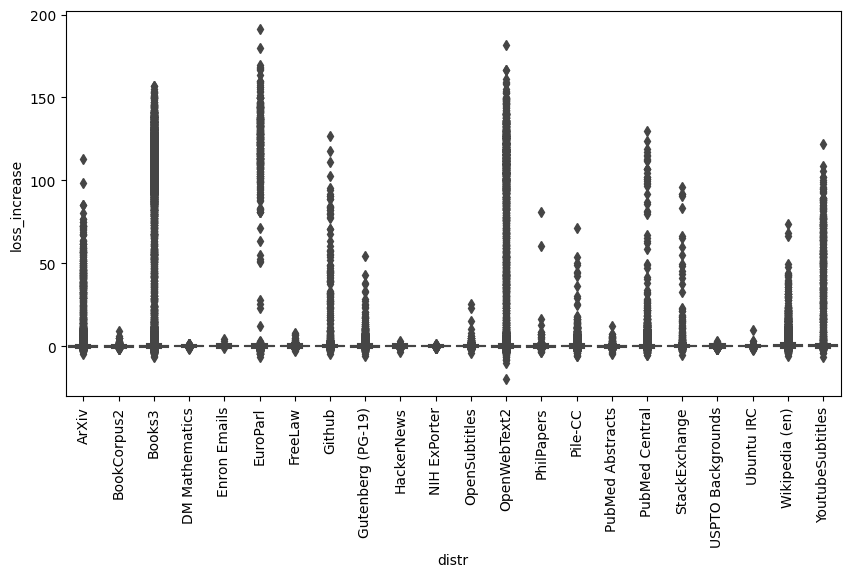

In [102]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='distr', y='loss_increase', data=pile_seq_loss, ax=ax)
# change xticks to distribution names
ax.set_xticks(np.arange(len(distr_mapping)), list(distr_mapping.keys()), rotation=90);

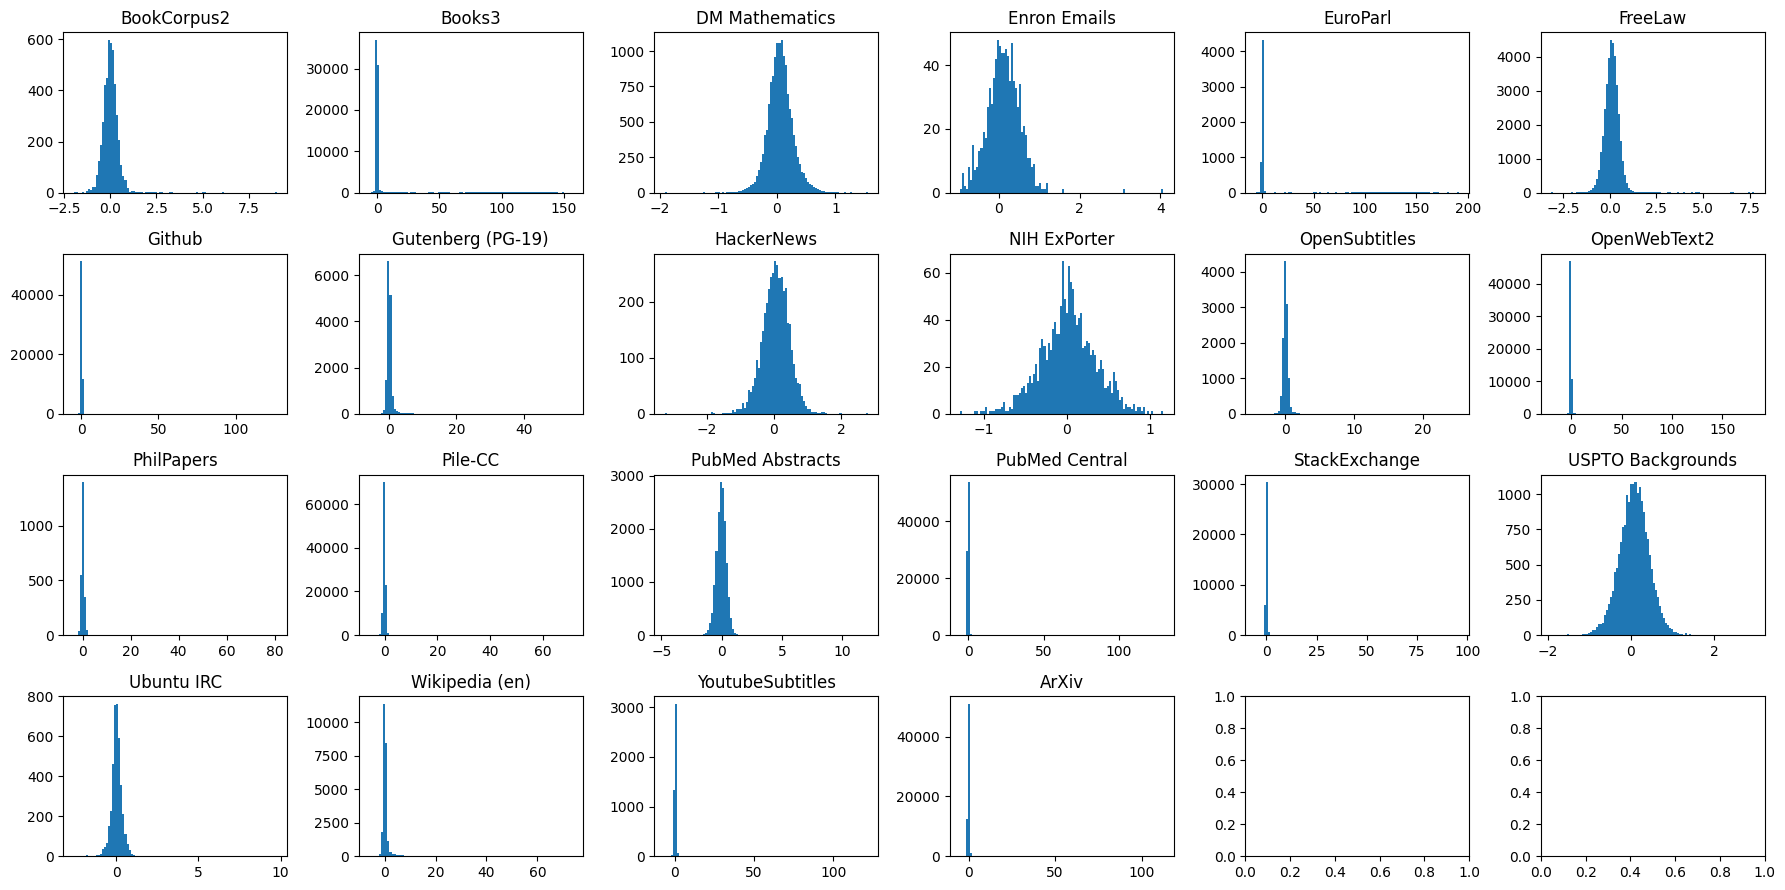

In [113]:
# histogram of loss increase for each sub-dataset
fig, axs = plt.subplots(4, 6, figsize=(18, 9))
for distr in distr_mapping:
    # if distr == 'europarl':
    #     continue
    ax=axs[distr_ix // 6, distr_ix % 6]
    distr_ix = distr_mapping[distr]
    distr_loss = pile_seq_loss.query(f'distr == {distr_ix}')['loss_increase']
    ax.hist(distr_loss, bins=100)
    ax.set_title(distr)
plt.tight_layout()

In [110]:
distr_mapping

{'ArXiv': 0,
 'BookCorpus2': 1,
 'Books3': 2,
 'DM Mathematics': 3,
 'Enron Emails': 4,
 'EuroParl': 5,
 'FreeLaw': 6,
 'Github': 7,
 'Gutenberg (PG-19)': 8,
 'HackerNews': 9,
 'NIH ExPorter': 10,
 'OpenSubtitles': 11,
 'OpenWebText2': 12,
 'PhilPapers': 13,
 'Pile-CC': 14,
 'PubMed Abstracts': 15,
 'PubMed Central': 16,
 'StackExchange': 17,
 'USPTO Backgrounds': 18,
 'Ubuntu IRC': 19,
 'Wikipedia (en)': 20,
 'YoutubeSubtitles': 21}

In [94]:
distr_mapping

{'ArXiv': 0,
 'BookCorpus2': 1,
 'Books3': 2,
 'DM Mathematics': 3,
 'Enron Emails': 4,
 'EuroParl': 5,
 'FreeLaw': 6,
 'Github': 7,
 'Gutenberg (PG-19)': 8,
 'HackerNews': 9,
 'NIH ExPorter': 10,
 'OpenSubtitles': 11,
 'OpenWebText2': 12,
 'PhilPapers': 13,
 'Pile-CC': 14,
 'PubMed Abstracts': 15,
 'PubMed Central': 16,
 'StackExchange': 17,
 'USPTO Backgrounds': 18,
 'Ubuntu IRC': 19,
 'Wikipedia (en)': 20,
 'YoutubeSubtitles': 21}

In [75]:
dataset

Dataset({
    features: ['tokens', 'distribution'],
    num_rows: 649011
})

In [125]:
pile_seq_loss.reset_index().sort_values('loss_increase', ascending=False).groupby('distr').head(1)

,seq_ix,loss_increase,distr
0,161622,191.353104,5
1,347554,181.696014,12
20,93474,156.844315,2
528,529085,129.541962,16
665,243661,126.722450,7
941,645940,121.874092,21
1527,54840,112.682671,0
2478,565026,95.874016,17
2933,353833,80.980347,13
3056,633828,73.823830,20


In [128]:
sum(loss_list)

-121.87409234046936

In [130]:
top_loss_seqs = pile_seq_loss.reset_index().sort_values('loss_increase', ascending=False).groupby('distr').head(1)
for distr in distr_mapping:
    distr_ix = distr_mapping[distr]
    seq_ix = top_loss_seqs.query(f'distr == {distr_ix}')['seq_ix'].values[0]
    loss_list = pile_loss_dif[seq_ix].tolist()
    token_list = [decoded_vocab[t] for t in dataset[int(seq_ix)]['tokens'].tolist()[:-1]]
    print(f'{distr}: {seq_ix}; loss: {sum(loss_list):.2f}')
    display(colored_tokens(token_list, loss_list))
    

ArXiv: 54840; loss: 112.68


BookCorpus2: 67199; loss: 9.00


Books3: 93474; loss: 156.84


DM Mathematics: 151065; loss: 1.56


Enron Emails: 156062; loss: 4.07


EuroParl: 161622; loss: 191.35


FreeLaw: 183570; loss: 7.76


Github: 243661; loss: 126.72


Gutenberg (PG-19): 270783; loss: 54.50


HackerNews: 278877; loss: 2.81


NIH ExPorter: 280313; loss: 1.16


OpenSubtitles: 287615; loss: 25.23


OpenWebText2: 347554; loss: 181.70


PhilPapers: 353833; loss: 80.98


Pile-CC: 428463; loss: 71.08


PubMed Abstracts: 472119; loss: 12.12


PubMed Central: 529085; loss: 129.54


StackExchange: 565026; loss: 95.87


USPTO Backgrounds: 603959; loss: 2.97


Ubuntu IRC: 616787; loss: 9.78


Wikipedia (en): 633828; loss: 73.82


YoutubeSubtitles: 645940; loss: 121.87


In [ ]:
def display_seqs(seqs):
    for i in seqs:
        i = int(i)
        token_list = [decoded_vocab[t] for t in dataset[i]['tokens'].tolist()]
        activation_list = ep_activations[i].tolist()
        display(colored_tokens(token_list, activation_list))